## Load Network

In [1]:
from rlsm.datasets import load_illinois_highschool

Y = load_illinois_highschool()

## Conditionally Edge-Independent Model

In [12]:
model_no = ReciprocityLSM(n_features=2, reciprocity_type='none', random_state=42)
model_no.sample(Y, n_warmup=2500, n_samples=5000)

sample: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7500/7500 [12:20<00:00, 10.13it/s, 127 steps of size 3.66e-02. acc. prob=0.82]


In [8]:
model_no.print_summary()

AUC: 0.969, AIC: 1681.858, BIC: 3496.986, DIC: 1453.332

                mean       std    median      2.5%     97.5%     n_eff     r_hat
     r_var      1.71      0.50      1.64      0.85      2.72   1447.40      1.00
     s_var      0.40      0.14      0.38      0.16      0.66   2554.36      1.00
   sr_corr      0.57      0.28      0.60      0.08      1.00    386.18      1.00
     z_var     18.45      3.14     18.15     12.57     24.36   1973.20      1.00

Number of divergences: 52


## Homogeneous Model

In [6]:
model_con = ReciprocityLSM(n_features=2, reciprocity_type='constant', random_state=42)
model_con.sample(Y, n_warmup=2500, n_samples=5000)

sample: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7500/7500 [17:20<00:00,  7.21it/s, 127 steps of size 4.40e-02. acc. prob=0.79]


In [11]:
model_con.print_summary()

AUC: 0.968, AIC: 1684.701, BIC: 3311.538, DIC: 1464.336

                  mean       std    median      2.5%     97.5%     n_eff     r_hat
       r_var      1.60      0.47      1.54      0.82      2.54   1758.50      1.00
  recip_coef      1.67      0.28      1.67      1.12      2.21   1455.35      1.01
       s_var      0.37      0.12      0.35      0.16      0.60   2804.20      1.00
     sr_corr     -0.56      0.30     -0.60     -1.00     -0.01    399.05      1.02
       z_var     11.98      2.28     11.75      7.90     16.52   1287.37      1.01

Number of divergences: 67


## Distance-Dependent Model

In [2]:
from rlsm import ReciprocityLSM

model_dis = ReciprocityLSM(n_features=2, reciprocity_type='distance', random_state=42)
model_dis.sample(Y, n_warmup=2500, n_samples=5000)

sample: 100%|█████████████████████████████████████████████████████████| 7500/7500 [13:41<00:00,  9.13it/s, 127 steps of size 3.90e-02. acc. prob=0.82]


In [3]:
model_dis.print_summary()

AUC: 0.968, AIC: 1640.938, BIC: 3273.564, DIC: 1420.490

                  mean       std    median      2.5%     97.5%     n_eff     r_hat
   dist_coef     -1.19      0.43     -1.16     -2.01     -0.38   1701.07      1.00
       r_var      1.65      0.50      1.58      0.87      2.74   1513.99      1.00
  recip_coef      3.65      0.70      3.62      2.31      5.01   2322.06      1.00
       s_var      0.40      0.14      0.38      0.17      0.68   2432.22      1.00
     sr_corr     -0.22      0.40     -0.22     -1.00      0.44    231.62      1.02
       z_var     10.05      2.08      9.83      6.26     14.15   1767.19      1.00

Number of divergences: 62


## Reciprocity Parameters (Figure 9)

Text(0.5, 1.0, '(2.37, 5.10)')

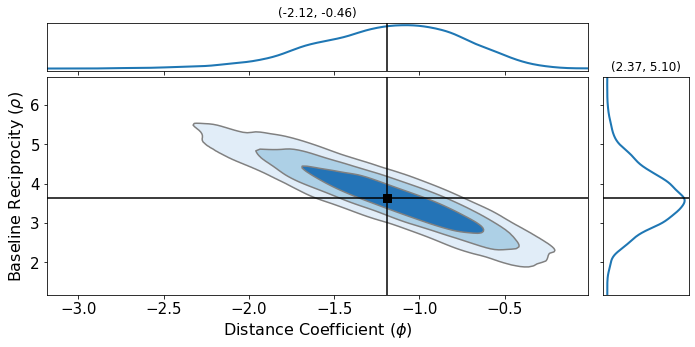

In [5]:
import arviz as az

ax = az.plot_pair(
    {r"$\phi$": model_dis.samples_['dist_coef'][None, ...],
     r"$\rho$": model_dis.samples_['recip_coef'][None, ...]},
    var_names=[r"$\phi$", r"$\rho$"],
    kind="kde",
    kde_kwargs={"hdi_probs": [0.5, 0.8, 0.95], "contourf_kwargs": {"cmap": "Blues"}},
    marginals=True,
    point_estimate="mean",
    figsize=(11.5, 5),
)

ax[1,0].set_xlabel(r"Distance Coefficient ($\phi$)", fontsize=16)
ax[1,0].set_ylabel(r"Baseline Reciprocity ($\rho$)", fontsize=16)
ax[1,0].tick_params(labelsize=15)

phi = model_dis.samples_['dist_coef']
rho = model_dis.samples_['recip_coef']
phi_ci = np.quantile(phi, q=[0.025, 0.975])
rho_ci = np.quantile(rho, q=[0.025, 0.975])
ax[0, 0].set_title(f"({phi_ci[0]:.2f}, {phi_ci[1]:.2f})")
ax[1, 1].set_title(f"({rho_ci[0]:.2f}, {rho_ci[1]:.2f})")

#plt.savefig('/Users/joshua/myworkspace/reciprocity-lsm/stat-submission/images/illinois_recip_ci.png', dpi=600, bbox_inches='tight')


## Log-Odds Ratios and Latent Space (Figure 10)

/var/folders/v3/2j2q_5r946l7qp1c47w5x7lc0000gn/T/ipykernel_55599/2201918061.py:14: RuntimeWarning: invalid value encountered in sqrt
  D = np.sqrt(pairwise_distance(model_dis.Z_))


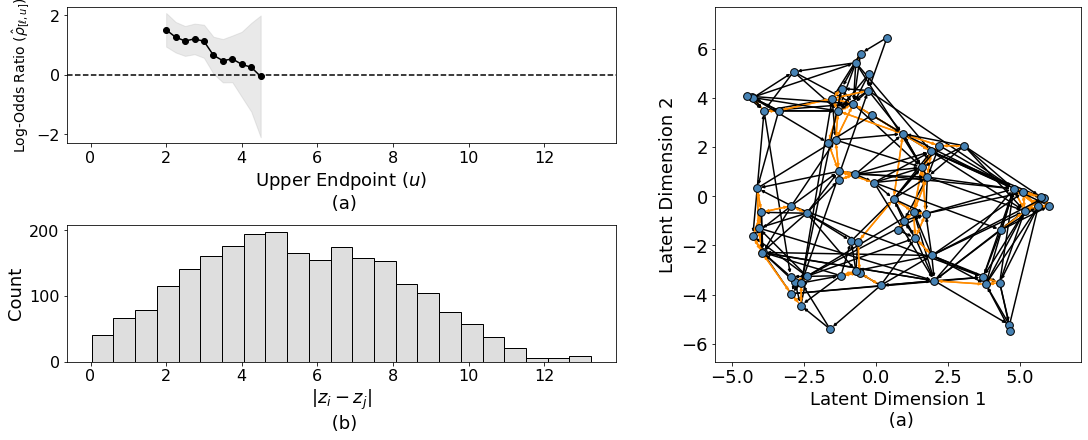

In [11]:
from rlsm.rlsm import pairwise_distance
from rlsm.network_utils import adjacency_to_dyads, dyads_to_multinomial
import networkx as nx
from sklearn.cluster import KMeans

ax = plt.figure(constrained_layout=True, figsize=(15,6)).subplot_mosaic(
    """
    AAABB
    CCCBB
    """,
    gridspec_kw={'wspace': 0.2}
)

D = np.sqrt(pairwise_distance(model_dis.Z_))
d = adjacency_to_dyads(D, n=D.shape[0])[:, 0]
dyads = adjacency_to_dyads(Y, n=D.shape[0])

res = []
res_se = []
qs = np.quantile(d, q=np.linspace(0, 1, 100))
dist = []
prods = []
diff = np.diff(qs)[0] 

start = 0.
step = 2.
end = start + step
while start < d.max():
    a = dyads_to_multinomial(dyads[np.where(np.logical_and(d >= start, d <= end))[0]])
           
    tots = a.sum(axis=0) 
    prods.append(tots[1] * tots[2])
    gamma = (tots[0] * tots[-1]) / (tots[1] * tots[2]) 
    if np.prod(tots) > 0:
        res.append(np.log(gamma))
        res_se.append(np.sqrt(np.sum(1/tots)))
        dist.append(end)
        
    start += 0.25
    end += 0.25

sns.histplot(d, color='lightgray', edgecolor='k', ax=ax['C'])
ax['A'].plot(np.asarray(dist), res, 'ko-')
ax['A'].set_ylabel(r'Log-Odds Ratio $(\hat{\rho}_{[\ell, u]})$', fontsize=14)
ax['A'].set_xlabel('Upper Endpoint ($u$)\n (a)', fontsize=18)
ax['C'].set_ylabel('Count', fontsize=18)
ax['C'].set_xlabel(r'$|z_i - z_j|$'+ '\n (b)', fontsize=18)
ax['A'].axhline(0., color='k', linestyle='--')
ses = 1.96 * np.asarray(res_se)
res = np.asarray(res)
ax['A'].fill_between(np.asarray(dist), res + ses, res - ses, color='darkgray', alpha=0.25)

g = nx.from_numpy_array(Y, create_using=nx.DiGraph)
pos = {k : model_dis.Z_[k, :2] for k in range(Y.shape[0])}
elist = list(nx.to_edgelist(g))
ecolor = ['darkorange' if Y[e[1], e[0]] else 'k' for e in elist]
nx.draw_networkx(g, pos, 
                 node_color='steelblue', edgecolors='k',
                 edge_color=ecolor, width=1.5, with_labels=False,
                 arrowsize=5,
                 node_size=60, ax=ax['B'])
ax['A'].tick_params(left=True, bottom=True, labelleft=True, labelbottom=True,
                labelsize=16)
ax['C'].tick_params(left=True, bottom=True, labelleft=True, labelbottom=True,
                labelsize=16)
ax['B'].tick_params(left=True, bottom=True, labelleft=True, labelbottom=True,
                labelsize=18)
ax['B'].set_ylabel('Latent Dimension 2', fontsize=18)
ax['B'].set_xlabel('Latent Dimension 1\n (a)', fontsize=18)
ax['A'].sharex(ax['C'])

## Conditionally Edge-Independent Latent Space (Figure 1)

Text(0.5, 0, 'Latent Dimension 1')

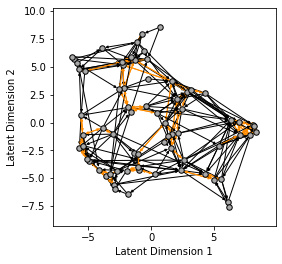

In [10]:
from scipy.linalg import orthogonal_procrustes

fig, ax = plt.subplots(figsize=(4,4))
g = nx.from_numpy_array(Y, create_using=nx.DiGraph)

Z_none = model_no.Z_
Z_dis = model_dis.Z_

R, _ = orthogonal_procrustes(Z_none, Z_dis)

Z_none = Z_none @ R

pos = {k : Z_none[k] for k in range(Y.shape[0])}
elist = list(nx.to_edgelist(g))
ecolor = ['darkorange' if Y[e[1], e[0]] else 'k' for e in elist]
nx.draw_networkx(g, pos, 
                 node_color='darkgray', edgecolors='k',
                 edge_color=ecolor, width=1, with_labels=False,
                 arrowsize=5,
                 node_size=30, ax=ax)
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True,
                labelsize=10)
ax.set_ylabel('Latent Dimension 2')
ax.set_xlabel('Latent Dimension 1')